# EX5: Controlar el robot con una red neuronal

## Introducción

Esta práctica tiene como objetivo controlar un robot con una red neuronal. Es por eso que entrenaremos a una red neuronal con datos de sensores de robot y órdenes que se darán al robot para seguir la pista. Una vez que la red está entrenada, se puede usar para controlar el robot.

In [1]:
%pip install aitk aitk.robots aitk.networks tensorflow numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.4/310.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.1 MB/s eta 0:00:00


In [36]:
import random

import aitk.networks as nets
import numpy as np
import aitk.robots as bots

import keras

import matplotlib.pyplot as plt
import cv2
import requests

# Define the custom metric 'tolerance_accuracy'
def tolerance_accuracy(y_true, y_pred):
    """Custom metric function to calculate accuracy within a tolerance.
    For this example, I will consider a 0.1 threshold, but you need to adjust to your case.
    """

    #Pareix que la versió de keras s'ha actualitzat y keras.bakend.mean y .abs no funcionen
    return keras.ops.mean(keras.ops.abs(y_true - y_pred) <= 0.1)
    # return keras.backend.mean(keras.backend.abs(y_true - y_pred) <= 0.1)


In [28]:
import keras
print(keras.__version__)

3.8.0


# Cargar datos de la Red Neuronal "guardada" previamente

Si ya hemos entrenado la red y solo queremos volver a controlar el robot con esa mima red neuronal, podemos cargar el fichero .keras que habíamos guardado.

La siguiente celda solo la puedes ejecutar si tienes el fichero robot.keras previamente guardado (de un proceso anterior)

In [3]:
robot_net = keras.saving.load_model("robot.keras", custom_objects={'tolerance_accuracy': tolerance_accuracy})

ValueError: File not found: filepath=robot.keras. Please ensure the file is an accessible `.keras` zip file.

## Creación de la función para leer los datos de entrenamiento

Crearemos una función que lea los datos de entrenamiento y nos devuelva una lista de patrones donde cada elemento en la lista es un patrón de entrada y un patrón de salida. Además, nos mostrará la cantidad de patrones leídos.

In [3]:
def carrega_dades_entrenament(nom_fitxer):
    """Devolver datos de entrenamiento"""

    data = []
    with open(nom_fitxer, "r") as f:
        for line in f:
            split_line = line.strip().split(" ")
            float_line = [float(x) for x in split_line]
            data.append(float_line)
    print(len(data), " ejemplos cargados")
    return data

In [4]:
patrons = carrega_dades_entrenament("training_data.txt")
len(patrons)

2710  ejemplos cargados


2710

In [5]:
# Vejam quants paràmetres tenen els patrons
print(len(patrons[0]))

3


In [6]:
# Observem un exemple
print(patrons[0])

[0.16, 0.5, 0.2]


In [9]:
print(patrons)

[[0.16, 0.5, 0.2], [0.18, 0.5, 0.2], [0.2, 0.5, 0.2], [0.22, 0.5, 0.2], [0.26, 0.5, 0.2], [0.3, 0.5, 0.2], [0.26, 0.5, 0.2], [0.22, 0.5, 0.2], [0.16, 0.5, 0.2], [0.12, 0.5, 0.2], [0.08, 0.5, 0.2], [0.04, 0.5, 0.2], [0.04, 0.5, 0.2], [0.02, 0.5, 0.2], [0.0, 0.5, 0.0], [-0.02, 0.5, -0.2], [-0.04, 0.5, -0.2], [-0.08, 0.5, -0.2], [-0.14, 0.5, -0.2], [-0.2, 0.5, -0.2], [-0.28, 0.5, -0.2], [0.28, 0.5, 0.2], [0.24, 0.5, 0.2], [0.2, 0.5, 0.2], [0.16, 0.5, 0.2], [0.12, 0.5, 0.2], [0.1, 0.5, 0.2], [0.08, 0.5, 0.2], [0.06, 0.5, 0.2], [0.04, 0.5, 0.2], [0.02, 0.5, 0.2], [0.0, 0.5, 0.0], [0.0, 0.5, 0.0], [-0.02, 0.5, -0.2], [-0.06, 0.5, -0.2], [-0.1, 0.5, -0.2], [-0.18, 0.5, -0.2], [-0.36, 0.5, -0.2], [-0.32, 0.5, -0.2], [-0.28, 0.5, -0.2], [-0.22, 0.5, -0.2], [-0.2, 0.5, -0.2], [-0.18, 0.5, -0.2], [-0.14, 0.5, -0.2], [-0.12, 0.5, -0.2], [-0.08, 0.5, -0.2], [-0.06, 0.5, -0.2], [-0.04, 0.5, -0.2], [0.0, 0.5, 0.0], [0.08, 0.5, 0.2], [0.02, 0.5, 0.2], [0.18, 0.5, 0.2], [0.16, 0.5, 0.2], [0.14, 0.5, 0.

## Preprocesamiento y balanceo de datos

Las herramientas de aprendizaje automático, incluidas las redes neuronales, encontrarán la forma más directa de reducir el error. Haremos un análisis de los datos que hemos recopilado. Crearemos una función auxiliar para contar en qué porcentaje de nuestros datos de entrenamiento hacen que el robot avance, avance hacia la izquierda o avance hacia la derecha.

La función debe tomar una lista de patrones como entrada y devolver una lista de tres valores: el porcentaje de patrones con movimiento hacia adelante, el porcentaje de patrones con movimiento izquierdo y el porcentaje de patrones con movimiento a la derecha.

In [10]:
def classifica_moviments(patterns):
    """Devuelve una lista de tres valores:
    - El porcentaje de patrones con movimiento hacia adelante,
    - El porcentaje de patrones con movimiento izquierdo (positivo) y
    - El porcentaje de patrones con movimiento a la derecha (negativo)."""
    total = len(patterns)
    adelante = 0
    izquierda = 0
    derecha = 0

    for linea in patterns:
        rotacion = float(linea[2])

        if rotacion == 0:
            adelante += 1
        elif rotacion < 0:
            izquierda += 1
        else:
            derecha += 1

    porcentage_adelante = adelante / total * 100
    porcentage_izquierda = izquierda / total * 100
    porcentage_derecha = derecha / total * 100

    return [porcentage_adelante, porcentage_izquierda, porcentage_derecha]

In [11]:
classifica_moviments(patrons)

[0.4797047970479705, 49.335793357933575, 50.184501845018445]

En robótica es típico que el robot se mueva más hacia el objetivo que hacia la derecha o hacia la izquierda. Por lo tanto, es probable que la red neuronal aprenda a avanzar hacia el objetivo y no a girar. Por eso es importante que los datos esten balanceados. Para lograr esto, dividiremos los datos en tres listas, una para cada tipo de movimiento y mezclaremos las listas, luego tomaremos el mismo número de patrones de cada lista y mezclaremos nuevamente. Esto nos dará un conjunto balanceado.

In [12]:
def balanceja_moviments(patrons):
    """Devuelve una lista de patrones con un número igual de ejemplos para cada tipo de movimiento"""
    adelante = []
    izquierda = []
    derecha = []

    for linea in patrons:
      rotacion = float(linea[2])
      if rotacion == 0:
        adelante.append(linea)
      elif rotacion < 0:
        izquierda.append(linea)
      else:
        derecha.append(linea)

    # Mezclamos las listas
    random.shuffle(adelante)
    random.shuffle(izquierda)
    random.shuffle(derecha)

    longitud_minima = min(len(adelante), len(izquierda), len(derecha))

    adelante = adelante[:longitud_minima]
    izquierda = izquierda[:longitud_minima]
    derecha = derecha[:longitud_minima]

    patrons_balancats = adelante + izquierda + derecha
    random.shuffle(patrons_balancats)

    return patrons_balancats

In [13]:
patrons_balancats = balanceja_moviments(patrons)
print(len(patrons_balancats))

39


Podemos tratar de entrenar la red neuronal con los datos balanceados y ver cómo se comporta. Si la red neuronal no aprende, podemos intentarlo con el conjunto de datos original.

In [14]:
patrons_entrenament = patrons[:int(len(patrons) * 0.8)]
patrons_validacio = patrons[int(len(patrons) * 0.8):]

def separa_dades(dades):
    """Devuelve dos listas: una con los datos de entrada y el otro con los datos de salida."""
    x = []
    y = []
    for dada in dades:
        x.append(dada[0])
        y.append(dada[-2:])
    # Convert x and y to NumPy arrays
    return np.array(x), np.array(y)
    # Original de Carles:
    # return x, y

x_train, y_train = separa_dades(patrons_entrenament)
x_test, y_test = separa_dades(patrons_validacio)

print(len(x_train), len(y_train))
print(x_train)
print(y_train)


2168 2168
[ 0.16  0.18  0.2  ... -0.42 -0.42 -0.42]
[[ 0.5  0.2]
 [ 0.5  0.2]
 [ 0.5  0.2]
 ...
 [ 0.5 -0.2]
 [ 0.5 -0.2]
 [ 0.5 -0.2]]


## Crear red de control de robots

Crearemos una red neuronal con tres capas: entrada, oculta y salida. Las entradas representarán los sensores de robot y las salidas representarán las acciones del robot. La capa oculta ayudará a transformar los sensores en las acciones correctas.

La red debe tener tantas entradas como haya usado en su algoritmo. Solo usamos el centro de la imagen, por lo que solo hay una entrada. Podía haber usado un enfoque diferente, como usar la imagen completa o usar más de un sensor. En este caso, debería tener más entradas.

Podemos usar `SimpleNetwork` de `aitk.networks` para crear la red, por su simplicidad e integración con `aitk.robots` o` keras` por su flexibilidad.

Comenzamos con un tamaño de capa oculta de 5, pero puedes experimentar con ella para ver qué tamaño funciona mejor.

El tamaño de la capa de salida debe ser 2, ya que esta capa representa las cantidades de traslación y rotación para mover el robot.

In [37]:
# robot_net = nets.SimpleNetwork(5, 2)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

robot_net = Sequential()
robot_net.add(Dense(5, input_dim=1, activation='relu'))  # Capa oculta con 5 neuronas
robot_net.add(Dense(2, activation='linear'))              # Capa de salida con 2 neuronas

# Compilar el modelo
robot_net.compile(
    loss='mean_squared_error',            # MSE como función de pérdida
    optimizer=Adam(learning_rate=0.01),   # Optimizador Adam
    metrics=[tolerance_accuracy]          # Tu métrica personalizada
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


El siguiente paso es entrenar la red neuronal. Debido a la naturaleza de los datos, probablemente necesitemos más tiempos de entrenamiento que en otras tareas.

In [ ]:
# A implementar por el alumnado (Entrenar la red neuronal)
import matplotlib.pyplot as plt

# robot_net.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

historial = robot_net.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=3000,
    verbose=1
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(historial.history['loss'], label='Training Loss')
plt.plot(historial.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico 2: Precisión (Accuracy) durante el entrenamiento
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(historial.history['tolerance_accuracy'], label='Training Accuracy')
plt.plot(historial.history['val_tolerance_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Ajusta el espaciado entre gráficos
plt.show()



Epoch 1/3000
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - tolerance_accuracy: 0.9533 - val_loss: 8.0561e-04 - val_tolerance_accuracy: 0.9733
Epoch 2/3000
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - tolerance_accuracy: 0.9593 - val_loss: 8.3598e-04 - val_tolerance_accuracy: 0.9733
Epoch 3/3000
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - tolerance_accuracy: 0.9526 - val_loss: 8.3803e-04 - val_tolerance_accuracy: 0.9733
Epoch 4/3000
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - tolerance_accuracy: 0.9562 - val_loss: 8.7178e-04 - val_tolerance_accuracy: 0.9733
Epoch 5/3000
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - tolerance_accuracy: 0.9557 - val_loss: 8.0603e-04 - val_tolerance_accuracy: 0.9733
Epoch 6/3000
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015 - tolerance_accuracy: 0.9507 - val_loss: 0.0010 - val_tolerance_accuracy: 0.9697
Epoch 7/3000
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - tolerance_accuracy: 0.9

Probamos la red neuronal con los datos de entrenamiento y vemos cómo se comporta.

In [ ]:
x_train[0]

out = robot_net.predict([x_train[0]])

out[0]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1,))
  warnings.warn(msg)


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.9974068 , -0.01484529], dtype=float32)>

## Creamos la función para controlar el robot

Una vez que la red neuronal esté entrenada, crearemos una función que use la red para controlar el robot. Esta característica debe tomar los datos de los sensores como una entrada y devolver los comandos para el robot.

In [ ]:
def network_driver(robot):
    # A implementar por el alumnado usando la red neuronal entrenada.

Finalmente, probaremos con el robot para ver cómo se comporta.

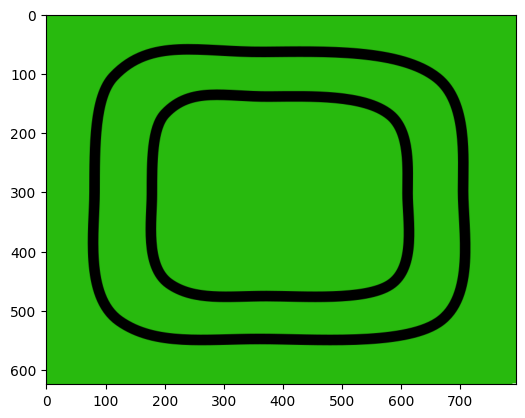

In [ ]:
nom_imatge = "EX2_pista_6.png"

# Cargamos la imagen en una variable

img = cv2.imread(nom_imatge)

# Mostramos la imagen
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
world = bots.World(220, 180, boundary_wall_color="yellow", ground_image_filename=nom_imatge)

robot = bots.Scribbler(x=36, y=90, a=90)
robot.add_device(bots.GroundCamera(width=100, height=50))

world.add_robot(robot)

robot['ground-camera'].watch()
world.watch()

Random seed set to: 4374487


HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00d\x00\x00\x002\x08\x06\x00\x00\x00\xaa5~\xbe\x00\…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

In [ ]:
world.reset()
world.seconds(30, [network_driver], real_time=True)

  0%|          | 0/300 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

In [ ]:
# Guardamos la red Neuronal
robot_net.save("robot.keras")

## Preguntas para responder

1. ¿Necesita algún tipo de memoria para que el robot alcance el objetivo? ¿Por qué?

2. ¿Qué porcentaje de los datos de entrenamiento hacen que el robot avance, hacia la izquierda y hacia la derecha?

3. ¿Qué tamaño de capa oculta funcionó mejor para ti?

4. El funcionamiento del robot controlado por la red neuronal es mejor, peor o lo mismo que el funcionamiento del robot controlado por tu algoritmo? ¿Podrías explicar por qué?

5. ¿Cómo podríamos hacer para mejorar el funcionamiento dle robot controlado por la red neuronal?

## Conclusiones

En esta práctica hemos aprendido a controlar un robot usando una red neuronal. Hemos visto cómo entrenar la red neuronal con datos de sensores y órdenes y cómo usar la red para controlar el robot. Hemos visto que la red neuronal puede ser una herramienta poderosa para controlar los robots, pero puede ser un tiempo de entrenamiento más largo que con otros métodos. También hemos visto que es importante balancear los datos de entrenamiento para que la red neuronal pueda aprender bien.

A veces puede que no sea fácil obtener los datos de entrenamiento necesarios para que la red neuronal funcione bien. En este caso, hemos utilizado datos simulados, pero en un entorno real, podría ser más complicado.

En la próxima práctica, veremos cómo entrenar a una red neuronal para controlar un robot sin la necesidad de datos de entrenamiento.